<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/fielddevelopment/npv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%%capture
!pip install neqsim

from neqsim.process import openprocess
import time
import pandas as pd
from neqsim.thermo import createfluid,fluid_df,TPflash,printFrame

from google.colab import data_table
data_table.enable_dataframe_formatter()

#Tax rules Norwegian Continental Shelf
https://blogg.pwc.no/skattebloggen/slik-er-petroleumsbeskatningen-i-norge

https://www.norskpetroleum.no/okonomi/petroleumsskatt/

https://gassco.eu/en/shippers/tariffs-and-areas/

# Estimate basis

In [47]:
# Technical data
production_efficiency = 0.94
gasreservoirvolume = 1e9 # m3
reservoirPressure = 150.0 #bara
reservoirTemperature = 75.0 # C
pipe_wall_roughness = 15e-6 #meter
welldepth = 1070 #meter

#Economic data
gasprice_for_ecconomy_analysis = 3.0 #NOK/Sm3
discountrate = 0.08 #%
tariffprice = 0.015 #NOK/Sm3
electricity_price = 1.0 #NOK/kWh
cost_per_well = 1000.0 #MNOK

# Tax rates
corporate_tax_rate = 0.22  #22% Corporate tax
special_tax_rate = 0.56  #56% Special petroleum tax
technical_special_tax=_rate = 0.718 #%

#Reservoir fluid

In [48]:
# Uncomment to create alternative well stream
wellStreamComposition = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-butane", "n-butane", "n-hexane", "water"],
        'MolarComposition[-]':  [0.5, 0.5, 90.0, 5.0, 2.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0],
 }
wellStreamCompositiondf = pd.DataFrame(wellStreamComposition)
reservoirFluid = fluid_df(wellStreamCompositiondf)
reservoirFluid.setMixingRule('classic')
reservoirFluid.setMultiPhaseCheck(True)
reservoirFluid.setPressure(reservoirPressure, 'bara')
reservoirFluid.setTemperature(reservoirTemperature, 'C')
TPflash(reservoirFluid)
printFrame(reservoirFluid)

| 0                  | 1          | 2          | 3           | 4   | 5   | 6               |
|:-------------------|:-----------|:-----------|:------------|:----|:----|:----------------|
|                    | total      | GAS        | AQUEOUS     |     |     |                 |
| nitrogen           | 4.87805E-3 | 4.9081E-3  | 3.43112E-8  |     |     | [mole fraction] |
| CO2                | 4.87805E-3 | 4.90802E-3 | 1.27856E-5  |     |     | [mole fraction] |
| methane            | 8.78049E-1 | 8.83458E-1 | 8.87301E-6  |     |     | [mole fraction] |
| ethane             | 4.87805E-2 | 4.9081E-2  | 2.48524E-8  |     |     | [mole fraction] |
| propane            | 1.95122E-2 | 1.96324E-2 | 3.09191E-11 |     |     | [mole fraction] |
| i-butane           | 1.46341E-2 | 1.47243E-2 | 1.77946E-13 |     |     | [mole fraction] |
| n-butane           | 1.46341E-2 | 1.47243E-2 | 2.44692E-13 |     |     | [mole fraction] |
| n-hexane           | 4.87805E-3 | 4.9081E-3  | 2.65852E-18 |     |  

#Economy calculation

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

def sum_up_to_i_or_last_six(expense_values, i):
    # Ensure i is within the valid range
    i = min(i, len(expense_values) - 1)

    # Sum up the elements from 0 to i (inclusive), or the last 6 elements, whichever is smaller
    return sum(expense_values[max(0, i-5):i+1])

    # Sum up the elements from 0 to i (inclusive)
    return sum(expense_values[:i+1])

def calceconomy(gasprice=gasprice_for_ecconomy_analysis):
  global df
  # Data initialization
  data = {
      'time': time,
      'production': gasproduction,
      'totalproductionoe': totalproducedoe,
      'yearlygasproduction':yearlygasproduction,
      'OPEX': operational_cost
  }

  df = pd.DataFrame(data)
  df['REVENUE'] = df['production'] * gasprice * 365

  # Creating past time data
  past_time_data = pd.DataFrame({'time': range(-5, 0)})
  df = pd.concat([past_time_data, df])
  df.sort_values(by='time', inplace=True)
  df.reset_index(drop=True, inplace=True)
  df.fillna(0, inplace=True)

  average_cost_per_year = total_cost / yearsDG3toDG4
  df['CAPEX'] = 0.0
  expense_values = [average_cost_per_year] * (yearsDG3toDG4 + 2)
  expense_values[0] = preDG3cost * 0.25
  expense_values[1] = preDG3cost * 0.75

  df['TARIFF'] = df['production'] * tariffprice

  # Assigning expense values
  for i, expense in enumerate(expense_values, start=-5):
      df.loc[df['time'] == i, 'CAPEX'] = expense

    # Assigning expense values
  totalCAPEX = df['CAPEX'].sum()
  df['corporateTaxRed'] = 0.0
  df['PetroleumTaxRed'] = 0.0
  for i, expense in enumerate(df['CAPEX'], start=0):
      #print('sum last six ', sum_up_to_i_or_last_six(df['CAPEX'],i))
      sumlastsix = sum_up_to_i_or_last_six(df['CAPEX'],i)
      df.loc[df['time'] == i-5, 'corporateTaxRed'] = sumlastsix/6
      df.loc[df['time'] == i-5, 'PetroleumTaxRed'] = df.loc[df['time'] == i-5, 'CAPEX'] - sumlastsix/6*corporate_tax_rate

  # Adjusting the time column
  df['time'] -= df['time'].min()

  df['corporate_tax'] = (df['REVENUE'] - df['corporateTaxRed']- df['OPEX']) * corporate_tax_rate
  df['petroleum_tax'] = (df['REVENUE'] - df['PetroleumTaxRed']- df['OPEX']) * technical_special_tax
  # NPV calculation
  df['NPV_before_tax'] = (df['REVENUE'] - df['CAPEX'] - df['OPEX'] - df['TARIFF']) / ((1 + discountrate) ** df['time'])
  df['NPV'] = (df['REVENUE'] - df['CAPEX'] - df['corporate_tax'] - df['petroleum_tax'] - df['OPEX'] - df['TARIFF']) / ((1 + discountrate) ** df['time'])
  df['cumulative_NPV_before_tax'] = df['NPV_before_tax'].cumsum() / 1e3
  df['cumulative_NPV'] = df['NPV'].cumsum() / 1e3
  return df["NPV"].sum()

#Case studies
We will study various consepts

1. Subsea tie back

#Case 1. Subsea tie back

## Design basis




In [50]:
#number of wells in operation as function of time after startup
numberOfWells = [6]*25

#Pipeline length to subsea
new_pipeline_length = 10 #km
new_pipline_height = 0.0 # meter
new_pipeline_diameter = 14.0 * 0.0254 # 14" flow line loop connecting all wells to subsea manifold

existing_pipeline_length = 80 #km
existing_pipeline_diameter = 24.0 * 0.0254 # 24" pipeline

#existing process
sea_depth = 300

#inlet conditions
inlet_pressure = 60.0 #bara

#project
yearsDG3toDG4 = 3
co2emissions_kwh = 0.0

max_gas_production = 10

##Production simulations

###Simulation file

In [53]:
from neqsim.process.processTools import simplereservoir
from neqsim import jNeqSim
import matplotlib.pyplot as plt

referenceNumerOfWells = 6
producxtionIndex = 10.0E-3 * numberOfWells[0]/referenceNumerOfWells

reservoirOps = jNeqSim.processSimulation.processEquipment.reservoir.SimpleReservoir("Well 1 reservoir")
reservoirOps.setReservoirFluid(reservoirFluid.clone(), gasreservoirvolume, 1.0, 10.0e7);
reservoirOps.setLowPressureLimit(10.0, 'bara')

producedGasStream = reservoirOps.addGasProducer("well number")
producedGasStream.setFlowRate(max_gas_production, "MSm3/day")

wellflow = jNeqSim.processSimulation.processEquipment.reservoir.WellFlow("well flow unit");
wellflow.setInletStream(producedGasStream);
wellflow.setWellProductionIndex(producxtionIndex);

pipe = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(wellflow.getOutletStream())
pipe.setPipeWallRoughness(pipe_wall_roughness);
pipe.setLength(welldepth);
pipe.setElevation(welldepth);
pipe.setDiameter(0.625);

pipeline = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(pipe.getOutletStream());
pipeline.setPipeWallRoughness(pipe_wall_roughness);
pipeline.setLength(new_pipeline_length*1e3);
pipeline.setElevation(0);
pipeline.setDiameter(new_pipeline_diameter);

pipeline2 = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(pipeline.getOutletStream());
pipeline2.setPipeWallRoughness(pipe_wall_roughness);
pipeline2.setLength(existing_pipeline_length*1e3);
pipeline2.setElevation(sea_depth);
pipeline2.setDiameter(existing_pipeline_diameter);

chokeValve = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("chocke");
chokeValve.setInletStream(pipeline2.getOutletStream());
chokeValve.setOutletPressure(inlet_pressure-1, "bara");

adjuster = jNeqSim.processSimulation.processEquipment.util.Adjuster("adjuster");
adjuster.setTargetVariable(pipeline2.getOutletStream(), "pressure",
    inlet_pressure, "bara");
adjuster.setAdjustedVariable(producedGasStream, "flow", "MSm3/day");
adjuster.setMaxAdjustedValue(max_gas_production);
adjuster.setMinAdjustedValue(1.0);

process = jNeqSim.processSimulation.processSystem.ProcessSystem();
process.add(reservoirOps);
process.add(wellflow);
process.add(pipe);
process.add(pipeline);
process.add(pipeline2);
process.add(chokeValve);
process.add(adjuster);
process.run();

print('reservoir pressure ', reservoirOps.getReservoirFluid().getPressure('bara'), ' bottom hole ', wellflow.getOutletStream().getPressure("bara"))

deltat = 60*60.0*365 * 24 * production_efficiency

time = []
gasproduction = []
yearlygasproduction = []
pressure = []
bottomholepressure = []
xmaspressure = []
topsidepressure = []
gasvolume = []
wateringas = []
totalproducedoe = []
waterrate = []

GIP =  reservoirOps.getGasInPlace("GSm3")
print("gas in place (GIP) ", GIP, " GSm3")

adjuster.setTargetVariable(pipeline2.getOutletStream(), "pressure",
    inlet_pressure, "bara");
process.run();

for t in range(0, 25):
    producxtionIndex = 10.000100751427403E-3 * numberOfWells[t]/referenceNumerOfWells
    wellflow.setWellProductionIndex(producxtionIndex);
    if(pipeline.getOutletStream().getPressure("bara")<lp_inlet_pressure):
      break
    if(t>=1):
      for k in range(10):
        reservoirOps.runTransient(deltat/10.0);
        process.run();
    time.append(t)
    pressure.append(reservoirOps.getReservoirFluid().getPressure('bara'))
    bottomholepressure.append(wellflow.getOutletStream().getPressure("bara"))
    xmaspressure.append(pipe.getOutletStream().getPressure("bara"))
    topsidepressure.append(pipeline2.getOutletStream().getPressure("bara"))
    gasproduction.append(reservoirOps.getGasProdution('Sm3/day')/1e6)
    yearlygasproduction.append(reservoirOps.getGasProdution('Sm3/day')/1e9*365.0*production_efficiency)
    waterrate.append(wellflow.getOutletStream().getFluid().getComponent('water').getFlowRate('kg/hr')/1000.0*24)

    try:
      gasvolume.append(reservoirOps.getReservoirFluid().getPhase("gas").getVolume("m3"))
      wateringas.append(reservoirOps.getReservoirFluid().getPhase("gas").getComponent('water').getx())
    except:
      gasvolume.append(0)
      wateringas.append(0)
    totalproducedoe.append(reservoirOps.getProductionTotal('MSm3 oe'))

reservoir pressure  150.0  bottom hole  146.66332994540764
gas in place (GIP)  139.057235664344  GSm3


###Results

total production  66.93740793706279  MSm3 oe
recovery rate  48.13658751180422  %


<ipython-input-54-c4222471f4d1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(7, 1, 1)


,time,production,totalproductionoe,yearlygasproduction,water,respressure,topsidepressure
0,0,9.971612,0.000000,3.421260,27.568477,150.000000,105.392015
1,1,9.971611,3.421260,3.421260,27.944420,146.290492,101.097020
2,2,9.971610,6.842519,3.421259,28.339189,142.604419,96.765546
3,3,9.971609,10.263779,3.421259,28.754208,138.939827,92.394250
4,4,9.971608,13.685038,3.421259,29.191236,135.294784,87.985424
5,5,9.971607,17.106296,3.421258,29.652230,131.667380,83.557090
6,6,9.971606,20.527555,3.421258,30.139372,128.055722,79.179428
7,7,9.971605,23.948813,3.421258,30.655108,124.457936,75.177026
8,8,9.971604,27.370070,3.421257,31.202182,120.872168,70.949568
9,9,9.971603,30.791327,3.421257,31.783689,117.296578,66.398364


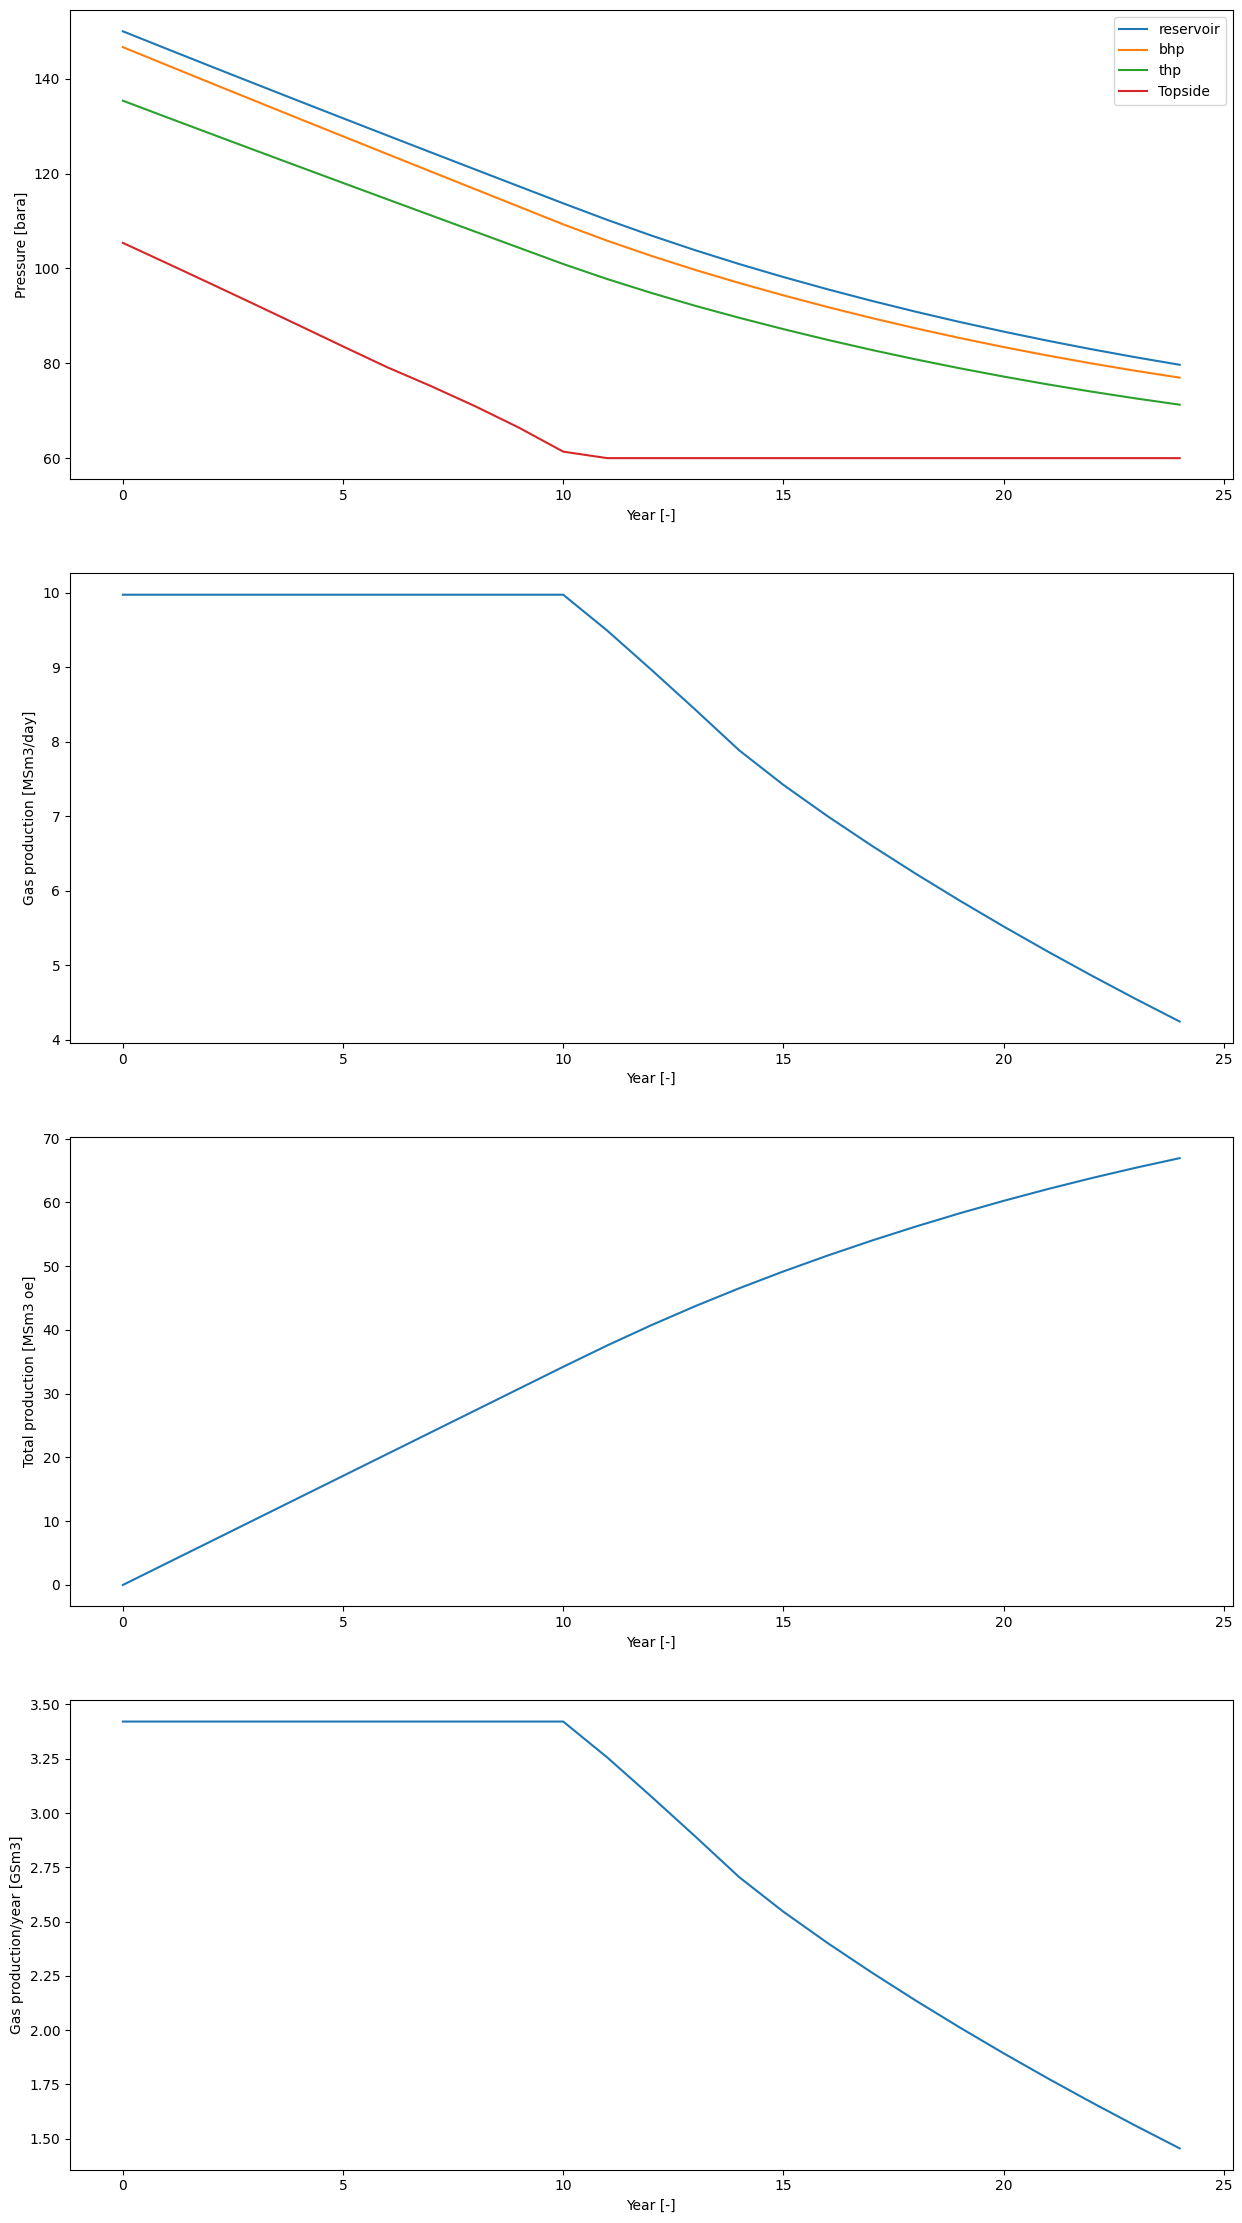

In [54]:
print('total production ', reservoirOps.getProductionTotal('MSm3 oe') , ' MSm3 oe')
print('recovery rate ', totalproducedoe[-1]/GIP*100 , ' %')
plt.rcParams['figure.figsize'] = [15, 50]
fig, ax = plt.subplots()
plt.subplot(7, 1, 1)
plt.xlabel('Year [-]')
plt.ylabel('Pressure [bara]')
plt.plot(time, pressure,label = "reservoir")
plt.plot(time, bottomholepressure, label="bhp")
plt.plot(time, xmaspressure, label="thp")
plt.plot(time, topsidepressure,label="Topside")
plt.legend()
plt.subplot(7, 1, 2)
plt.plot(time, gasproduction)
plt.xlabel('Year [-]')
plt.ylabel('Gas production [MSm3/day]')
plt.subplot(7, 1, 3)
plt.plot(time, totalproducedoe)
plt.xlabel('Year [-]')
plt.ylabel('Total production [MSm3 oe]')
plt.subplot(7, 1, 4)
plt.plot(time, yearlygasproduction)
plt.xlabel('Year [-]')
plt.ylabel('Gas production/year [GSm3]')

data2 = {
      'time': time,
      'production': gasproduction,
      'totalproductionoe': totalproducedoe,
      'yearlygasproduction':yearlygasproduction,
      'water': waterrate,
      'respressure': pressure,
      'topsidepressure':topsidepressure
  }

df2 = pd.DataFrame(data2)
df2.to_excel("productiondata.xlsx")
df2

##OPEX


In [55]:
operational_cost = 500 #MNOK/year
tariffprice = 0.2 #NOK/Sm3
print('tariff ', tariffprice, ' øre/Sm3')

tariff  0.2  øre/Sm3


##CAPEX

In [56]:
### capex contribution
total_well_cost = max(numberOfWells) * cost_per_well
print('well cost ', total_well_cost, ' MNOK')
surf_cost = 4500 #NOK
topside_facilities_cost = 1500
studies_cost = 100

total_cost = studies_cost + topside_facilities_cost + surf_cost + total_well_cost
preDG3cost = 200 #MNOK
print('totalcosts ',total_cost, ' MNOK')

well cost  6000.0  MNOK
totalcosts  12100.0  MNOK


##Economy analysis

REVENUE: 221.11 billions NOK
CAPEX: 12.30 billions NOK
NPV before tax: 63.70 billions NOK
NPV: 2.28 billions NOK


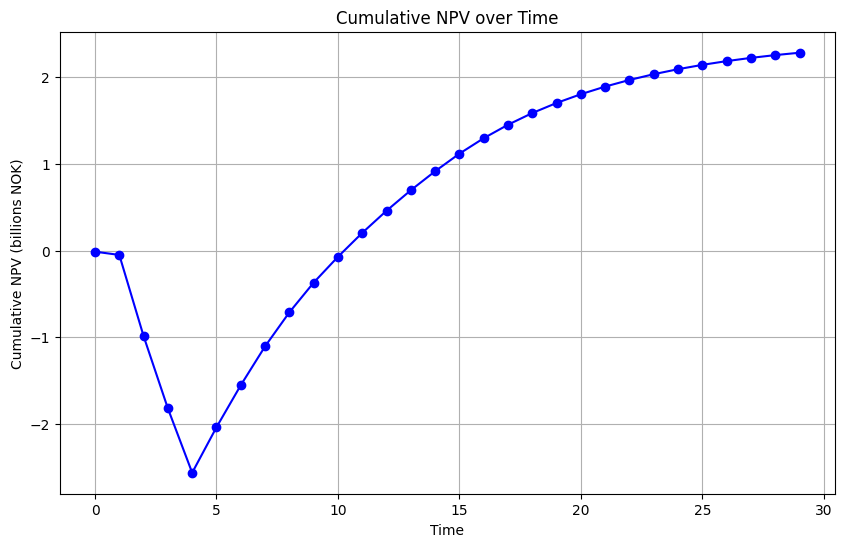

,time,production,totalproductionoe,yearlygasproduction,OPEX,REVENUE,CAPEX,TARIFF,corporateTaxRed,PetroleumTaxRed,corporate_tax,petroleum_tax,NPV_before_tax,NPV,cumulative_NPV_before_tax,cumulative_NPV
0,0,0.000000,0.000000,0.000000,0.0,0.000000,50.000000,0.000000,8.333333,48.166667,-1.833333,-34.583667,-50.000000,-13.583000,-0.050000,-0.013583
1,1,0.000000,0.000000,0.000000,0.0,0.000000,150.000000,0.000000,33.333333,142.666667,-7.333333,-102.434667,-138.888889,-37.251852,-0.188889,-0.050835
2,2,0.000000,0.000000,0.000000,0.0,0.000000,4033.333333,0.000000,705.555556,3878.111111,-155.222222,-2784.483778,-3457.933242,-937.609168,-3.646822,-0.988444
3,3,0.000000,0.000000,0.000000,0.0,0.000000,4033.333333,0.000000,1377.777778,3730.222222,-303.111111,-2678.299556,-3201.790039,-835.050128,-6.848612,-1.823494
4,4,0.000000,0.000000,0.000000,0.0,0.000000,4033.333333,0.000000,2050.000000,3582.333333,-451.000000,-2572.115333,-2964.620406,-742.540388,-9.813233,-2.566035
5,5,9.971612,0.000000,3.421260,500.0,10918.914822,0.000000,1.994322,2050.000000,-451.000000,1841.161261,7804.598842,7089.581057,524.838808,-2.723652,-2.041196
6,6,9.971611,3.421260,3.421260,500.0,10918.913842,0.000000,1.994322,2041.666667,-449.166667,1842.994378,7803.281805,6564.426287,485.636024,3.840775,-1.555560
7,7,9.971610,6.842519,3.421259,500.0,10918.912969,0.000000,1.994322,2016.666667,-443.666667,1848.494186,7799.332178,6078.171978,448.757960,9.918947,-1.106802
8,8,9.971609,10.263779,3.421259,500.0,10918.912050,0.000000,1.994322,1344.444444,-295.777778,1996.382873,7693.147296,5627.936521,392.984865,15.546883,-0.713817
9,9,9.971608,13.685038,3.421259,500.0,10918.911082,0.000000,1.994322,672.222222,-147.888889,2144.271549,7586.962379,5211.051850,343.012129,20.757935,-0.370805


In [57]:
calceconomy(gasprice_for_ecconomy_analysis)
# Output¨
print(f'REVENUE: {df["REVENUE"].sum() / 1e3:.2f} billions NOK')
print(f'CAPEX: {df["CAPEX"].sum() / 1e3:.2f} billions NOK')
print(f'NPV before tax: {df["NPV_before_tax"].sum() / 1e3:.2f} billions NOK')
print(f'NPV: {df["NPV"].sum() / 1e3:.2f} billions NOK')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['cumulative_NPV'], marker='o', color='b')
plt.title("Cumulative NPV over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative NPV (billions NOK)")
plt.grid(True)
plt.show()

df.to_excel("economydata.xlsx")
df

In [58]:
from scipy.optimize import fsolve
# Finding the minimum
breakevenprice = fsolve(calceconomy, x0=2.5)[0]
barrelperSm3gas = 6.29/1000.0
priceperbarrel =  breakevenprice/barrelperSm3gas
USDperbarrel = priceperbarrel/9.0

print('break even price ', breakevenprice, ' NOK/Sm3')
print('break even price ', USDperbarrel, ' US$/barrel')

print('+40% gas price')
calceconomy(gasprice_for_ecconomy_analysis*1.2)
print(f'NPV before tax: {df["NPV_before_tax"].sum() / 1e3:.2f} billions NOK')
print(f'NPV: {df["NPV"].sum() / 1e3:.2f} billions NOK')

print('-40% gas price')
calceconomy(gasprice_for_ecconomy_analysis*0.8)
print(f'NPV before tax: {df["NPV_before_tax"].sum() / 1e3:.2f} billions NOK')
print(f'NPV: {df["NPV"].sum() / 1e3:.2f} billions NOK')

break even price  1.5731189114953958  NOK/Sm3
break even price  27.78871067824405  US$/barrel
+40% gas price
NPV before tax: 79.19 billions NOK
NPV: 3.24 billions NOK
-40% gas price
NPV before tax: 48.21 billions NOK
NPV: 1.32 billions NOK



 ## CO2 emissions




In [59]:
#calculate co2 emissions each year
#co2 emissions

